# Índice

1. [Preparacion del Dataset](#preparaciondataset)

    1.1 [Visualización de los datos](#visualizaciondatos) <br>
    1.2 [Carga del Dataset](#cargadeldataset) <br>
    1.3 [Modificación de imagenes a baja y media resolución](#modimgs) <br>
    1.4 [Creación de los datasets](#creaciondatasets)
    
    - [a). Baja resolución (kxk)](#br) <br>
    - [b). Media resolución (mxm)](#mr)<br>
    - [c). Alta resolución (nxn)](#hr)
2. [Creación y Entrenamiento de modelos](#creacionentrenamientomodelos)

    2.1 [Autoencoder (Vanilla)](#ae) <br>
    2.2 [Variational Auto Encoder (VAE)](#vae) <br>
    2.3 [GAN (Sin U-Net)](#gan) <br>
    2.4 [GAN (U-Net o cGAN o pix2pix)](#cgan) <br>
    2.5 [SRGAN(?)](#srgan) <br>
    2.6 [ESRGAN(?)](#esrgan) <br>
3. [Comparación de modelos](#comparacionmodelos)

    3.1 [Métricas individuales](#mi) <br>
    3.2 [Tablas comparativas de métricas](#tcm) <br>
    3.3 [Comparativa de imágenes](#ci)

Imports:

In [1]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import cv2
import math

# 1. Preparación del Dataset <a id="preparaciondataset"></a>

## 1.1 Visualización de los datos <a id="visualizaciondatos"></a>

Vamos a abrir un par de imágenes para ver el contenido del dataset.

In [2]:
show_image = Image.open("./Dataset/DIV2K_train_HR/0001.png")
show_image.size

(2040, 1404)

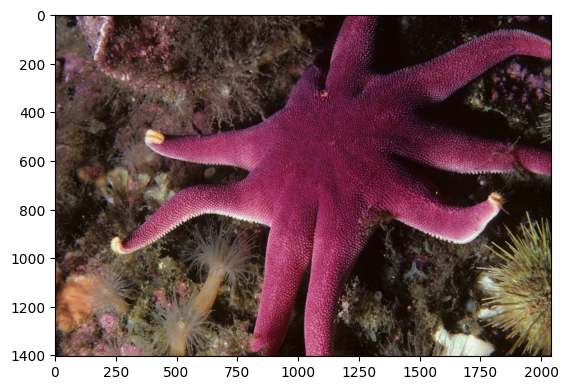

In [3]:
plt.imshow(show_image)

In [4]:
show_image = Image.open("./Dataset/DIV2K_train_HR/0124.png")
show_image.size

(1356, 2040)

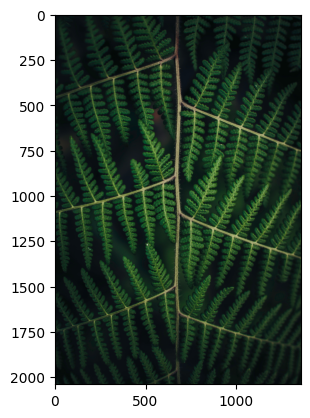

In [5]:
plt.imshow(show_image)

Como se puede observar, las imágenes tienen un tamaño constante de 2040 de ancho o de alto.

## 1.2 Carga del Dataset <a id="cargadeldataset"></a>

Se definen algunas variables globales como las rutas de los directorios del dataset

In [6]:
DIV2K_TRAIN_HR_PATH = "Dataset/DIV2K_train_HR/*.png"
DIV2K_VALID_HR_PATH = "Dataset/DIV2K_valid_HR/*.png"

En este caso se está haciendo uso del dataset DIV2k (Explicar un poco mas sobre este dataset)

Se define el número de batch

In [7]:
BATCH_SIZE = 1

## 1.3 Modificación de imagenes a baja y media resolución <a id="modimgs"></a>

Esta función la he encontrado aquí: https://gist.github.com/blzq/c87d42f45a8c5a53f5b393e27b1f5319

In [8]:
def gaussian_blur(img, kernel_size=2, sigma=50):
    def gauss_kernel(channels, kernel_size, sigma):
        ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
        xx, yy = tf.meshgrid(ax, ax)
        kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
        return kernel

    gaussian_kernel = gauss_kernel(tf.shape(img)[-1], kernel_size, sigma)
    gaussian_kernel = gaussian_kernel[..., tf.newaxis]

    img = tf.expand_dims(img, axis=0)  
    img_blurred = tf.nn.depthwise_conv2d(img, gaussian_kernel, [1, 1, 1, 1],
                                          padding='SAME', data_format='NHWC')
    img_blurred = tf.squeeze(img_blurred, axis=0)  

    return img_blurred

Añado una máscara y defino la cantidad de ruido y lo grande que es la máscara:

In [9]:
def corrupt_part_of_image(image, noise_level=0.1, corruption_level=0.04):
    
    mask = tf.random.uniform(tf.shape(image)[:2]) < corruption_level
    noise = tf.random.normal(tf.shape(image), stddev=noise_level)
    noise = (noise + 1.0) / 2.0
    corrupted_image = tf.where(mask[..., tf.newaxis], tf.clip_by_value(image + noise, 0.0, 1.0), image)
    
    return corrupted_image

In [10]:
def low_res(img):
    img = tf.image.resize(img,size=(256,256))
    img = gaussian_blur(img)
    img = corrupt_part_of_image(img)
    return img

In [11]:
def med_res(img):
    img = tf.image.resize(img,size=(512,512))
    img = gaussian_blur(img)
    img = corrupt_part_of_image(img)
    return img

Función para cargar una imagen png y la transforma a float32

In [12]:
def load(input_path):
    img = tf.io.read_file(input_path)
    img = tf.cast(tf.image.decode_png(img,channels=3),tf.float32)
    return img

Función para normalizar la imagen

In [13]:
def normalize(img):
    #img = (img / 127.5) - 1 # Normalización de la imagen entre [-1 y 1]
    img = img / 255 #Normalización de la imagen entre [0 y 1]
    return img

In [14]:
#Target = Ground Truth ; Input = Imagen que se va a meter al modelo
def low_res_img_map(input_path):

    target_img = load(input_path)
    target_img = tf.image.resize(target_img,size=(1024,1024))

    input_image = low_res(target_img)

    target_img = normalize(target_img)
    input_image = normalize(input_image)

    return input_image, target_img

def med_res_img_map(input_path):

    target_img = load(input_path)
    target_img = tf.image.resize(target_img,size=(1024,1024))

    input_image = med_res(target_img)

    target_img = normalize(target_img)
    input_image = normalize(input_image)

    return input_image, target_img

def high_res_img_map(input_path):
    
    target_img = load(input_path)
    target_img = tf.image.resize(target_img,size=(1024,1024))

    target_img = normalize(target_img)

    return target_img, target_img

## 1.4 Creación de los datasets <a id="creaciondatasets"></a>

 Esta función crea un dataset con un input y un target. 

In [15]:
def create_dataset(dataset_path, res_func):
    dataset = tf.data.Dataset.list_files(str(dataset_path))
    dataset = dataset.map(res_func, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

### a). Baja resolución (kxk) <a id="br"></a>

In [16]:
low_res_train_dataset = create_dataset(DIV2K_TRAIN_HR_PATH,low_res_img_map)
low_res_valid_dataset = create_dataset(DIV2K_VALID_HR_PATH,low_res_img_map)

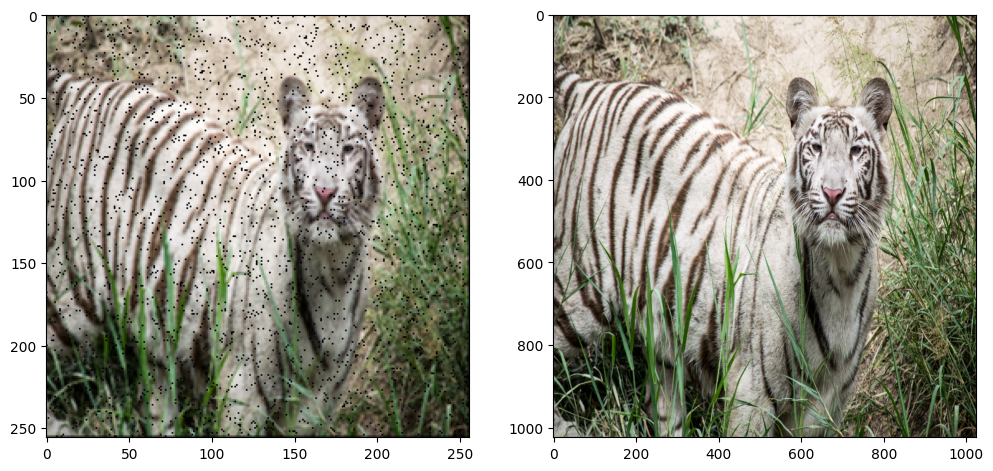

In [17]:
for a,b in low_res_train_dataset.as_numpy_iterator():
    fig, axs = plt.subplots(1, 2,figsize=(12,6))
    axs[0].imshow(a[0])
    axs[1].imshow(b[0])
    plt.show()
    break

### b). Media resolución (mxm) <a id="mr"></a>

In [18]:
med_res_train_dataset = create_dataset(DIV2K_TRAIN_HR_PATH,med_res_img_map)
med_res_valid_dataset = create_dataset(DIV2K_VALID_HR_PATH,med_res_img_map)

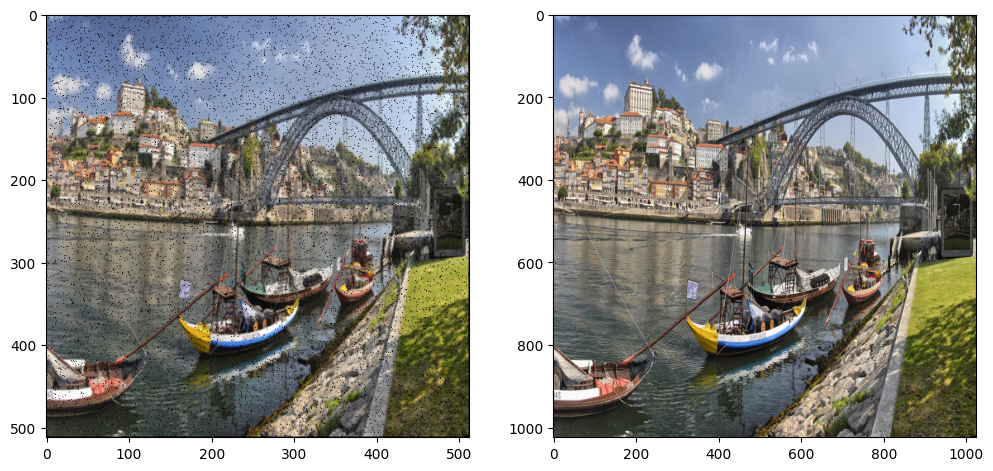

In [19]:
for c,d in med_res_train_dataset.as_numpy_iterator():
    fig, axs = plt.subplots(1, 2,figsize=(12,6))
    axs[0].imshow(c[0])
    axs[1].imshow(d[0])
    plt.show()
    break

### c). Alta resolución (nxn) <a id="hr"></a>

In [20]:
high_res_train_dataset = create_dataset(DIV2K_TRAIN_HR_PATH,high_res_img_map)
high_res_valid_dataset = create_dataset(DIV2K_VALID_HR_PATH,high_res_img_map)

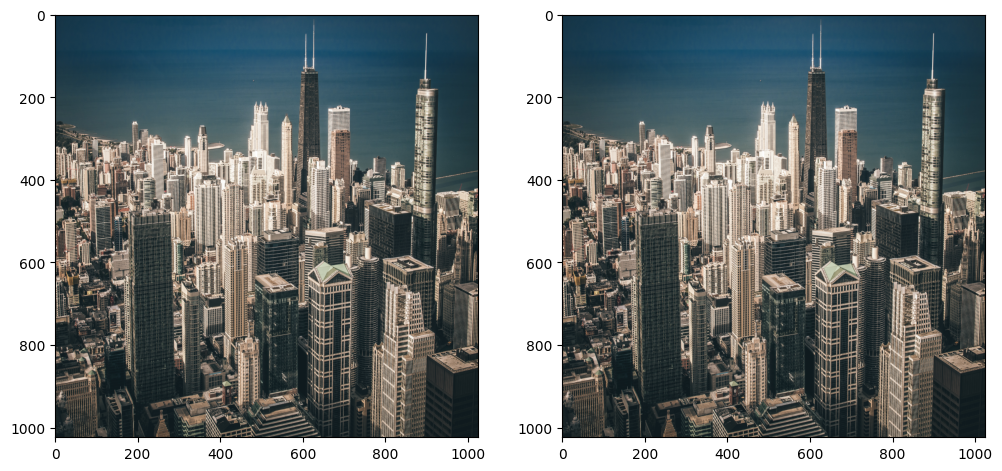

In [21]:
for e,f in high_res_train_dataset.as_numpy_iterator():
    fig, axs = plt.subplots(1, 2,figsize=(12,6))
    axs[0].imshow(e[0])
    axs[1].imshow(f[0])
    plt.show()
    break

# 2. Creación y Entrenamiento de modelos <a id="creacionentrenamientomodelos"></a>

Se comprueba que se detecta la tarjeta gráfica:

In [24]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 2.1 Autoencoder (Vanilla) <a id="ae"></a>

![Auto Encoder Vanilla](./Images/latent_representation_AE.png)

Se va a crear un autoencoder un tanto diferente, para este autoencoder vamos a utilizar entradas de datos diferentess a la salida. Se va a "intentar" reescalar las imágenes de 256 y 512 a 1024. Por último se va a entrenar el autoencoder normal para ver las diferencias:

In [ ]:
class Autoencoder(tf.keras.models.Model):
    def __init__(self,input_shape):
        super().__init__()
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=input_shape),
            tf.keras.layers.Convolution2D(128, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Convolution2D(256, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.UpSampling2D((2, 2)),
            tf.keras.layers.Convolution2D(256, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.UpSampling2D((2, 2)),
            tf.keras.layers.Convolution2D(128, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.UpSampling2D((2, 2)),
        ])

        if input_shape[0] == 1024:
            self.decoder.add(tf.keras.layers.Convolution2D(3, (3, 3), activation='sigmoid', padding='same'))
        

        if input_shape[0] == 512:
            self.decoder.add(tf.keras.layers.Convolution2D(128, (3, 3), activation='relu', padding='same'))
            self.decoder.add(tf.keras.layers.UpSampling2D((2, 2)))
            self.decoder.add(tf.keras.layers.Convolution2D(3, (3, 3), activation='sigmoid', padding='same'))
        
        if input_shape[0] == 256:
            self.decoder.add(tf.keras.layers.Convolution2D(128, (3, 3), activation='relu', padding='same'))
            self.decoder.add(tf.keras.layers.UpSampling2D((2, 2)))
            self.decoder.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='relu', padding='same'))
            self.decoder.add(tf.keras.layers.UpSampling2D((2, 2)))
            self.decoder.add(tf.keras.layers.Convolution2D(3, (3, 3), activation='sigmoid', padding='same'))


    def call(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
#tf.keras.utils.plot_model(autoencoder.decoder, show_shapes=True, dpi=64)

In [ ]:
autoencoder_256 = Autoencoder(input_shape=(256,256,3))
autoencoder_512 = Autoencoder(input_shape=(512,512,3))
autoencoder_1024 = Autoencoder(input_shape=(1024,1024,3))

In [ ]:
autoencoder_1024.compile(loss='mean_squared_error', optimizer='adam')
history_high_res = autoencoder_1024.fit(high_res_train_dataset, epochs=100)

Epoch 1/10
800/800 [==============================] - 387s 351ms/step - loss: 0.0337
Epoch 2/10
800/800 [==============================] - 279s 349ms/step - loss: 0.0228
Epoch 3/10
800/800 [==============================] - 279s 348ms/step - loss: 0.0217
Epoch 4/10
800/800 [==============================] - 278s 348ms/step - loss: 0.0219
Epoch 5/10
800/800 [==============================] - 278s 347ms/step - loss: 0.0205
Epoch 6/10
800/800 [==============================] - 278s 347ms/step - loss: 0.0206
Epoch 7/10
800/800 [==============================] - 278s 347ms/step - loss: 0.0181
Epoch 8/10
800/800 [==============================] - 278s 347ms/step - loss: 0.0150
Epoch 9/10
800/800 [==============================] - 278s 348ms/step - loss: 0.0143
Epoch 10/10
800/800 [==============================] - 278s 347ms/step - loss: 0.0139


In [ ]:
autoencoder_512.compile(loss='mean_squared_error', optimizer='adam')
history_mid_res = autoencoder_512.fit(med_res_train_dataset, epochs=200)

Epoch 1/10
800/800 [==============================] - 135s 145ms/step - loss: 0.0464
Epoch 2/10
800/800 [==============================] - 116s 145ms/step - loss: 0.0273
Epoch 3/10
800/800 [==============================] - 116s 145ms/step - loss: 0.0257
Epoch 4/10
800/800 [==============================] - 116s 145ms/step - loss: 0.0253
Epoch 5/10
800/800 [==============================] - 116s 145ms/step - loss: 0.0252
Epoch 6/10
800/800 [==============================] - 116s 145ms/step - loss: 0.0245
Epoch 7/10
800/800 [==============================] - 117s 146ms/step - loss: 0.0247
Epoch 8/10
800/800 [==============================] - 119s 148ms/step - loss: 0.0234
Epoch 9/10
800/800 [==============================] - 121s 151ms/step - loss: 0.0227
Epoch 10/10
800/800 [==============================] - 126s 157ms/step - loss: 0.0213


In [ ]:
autoencoder_256.compile(loss='mean_squared_error', optimizer='adam')
history_low_res = autoencoder_256.fit(low_res_train_dataset, epochs=300)

Epoch 1/15
800/800 [==============================] - 61s 70ms/step - loss: 0.0623
Epoch 2/15
800/800 [==============================] - 57s 71ms/step - loss: 0.0358
Epoch 3/15
800/800 [==============================] - 56s 69ms/step - loss: 0.0328
Epoch 4/15
800/800 [==============================] - 55s 68ms/step - loss: 0.0325
Epoch 5/15
800/800 [==============================] - 55s 68ms/step - loss: 0.0316
Epoch 6/15
800/800 [==============================] - 55s 68ms/step - loss: 0.0321
Epoch 7/15
800/800 [==============================] - 55s 68ms/step - loss: 0.0310
Epoch 8/15
800/800 [==============================] - 55s 68ms/step - loss: 0.0309
Epoch 9/15
800/800 [==============================] - 56s 69ms/step - loss: 0.0302
Epoch 10/15
800/800 [==============================] - 55s 69ms/step - loss: 0.0305
Epoch 11/15
800/800 [==============================] - 55s 69ms/step - loss: 0.0298
Epoch 12/15
800/800 [==============================] - 55s 69ms/step - loss: 0.0292
E

In [ ]:

autoencoder_256.save("Checkpoints/Autoencoder/autoencoder_256_model")
autoencoder_512.save("Checkpoints/Autoencoder/autoencoder_512_model")
autoencoder_1024.save("Checkpoints/Autoencoder/autoencoder_1024_model")

INFO:tensorflow:Assets written to: Checkpoints/Autoencoder/autoencoder_256_model\assets


INFO:tensorflow:Assets written to: Checkpoints/Autoencoder/autoencoder_256_model\assets


INFO:tensorflow:Assets written to: Checkpoints/Autoencoder/autoencoder_512_model\assets


INFO:tensorflow:Assets written to: Checkpoints/Autoencoder/autoencoder_512_model\assets


INFO:tensorflow:Assets written to: Checkpoints/Autoencoder/autoencoder_1024_model\assets


INFO:tensorflow:Assets written to: Checkpoints/Autoencoder/autoencoder_1024_model\assets


In [ ]:
def plot_one_image(model,valid_dataset):
    input, target = next(iter(valid_dataset))
    input = input.numpy()
    target = target.numpy()

    plt.subplot(1, 3, 1)
    plt.imshow(input[0]) 
    plt.title('Input')

    plt.subplot(1, 3, 2)
    plt.imshow(target[0])  
    plt.title('Ground Truth')

    plt.subplot(1, 3, 3)
    plt.imshow(model.predict(input)[0]) 
    plt.title('Prediction')

    plt.show()

Obviamente los autoencoders NO están hechos para la reconstrucción con imágenes de tamaños diferentes:

1/1 [==============================] - 0s 114ms/step


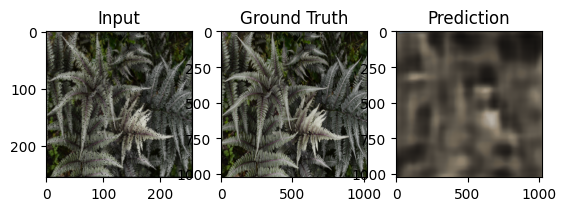

In [ ]:
plot_one_image(autoencoder_256,low_res_valid_dataset)

1/1 [==============================] - 0s 97ms/step


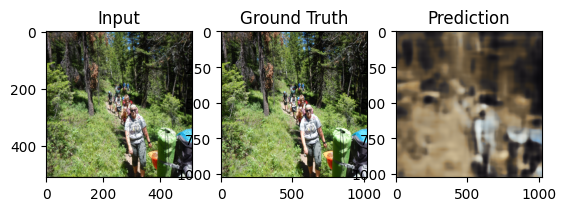

In [ ]:
plot_one_image(autoencoder_512,med_res_valid_dataset)

Aquí vemos una predicción que se acerca al ground truth pero se sigue sin ver nítido:

1/1 [==============================] - 0s 106ms/step


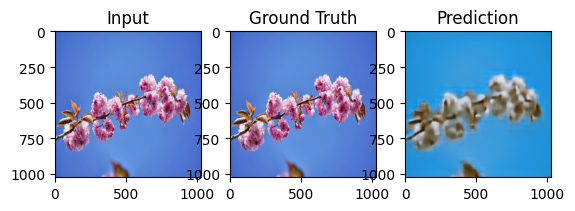

In [ ]:
plot_one_image(autoencoder_1024,high_res_valid_dataset)

## 2.2 Variational Auto Encoder (VAE) <a id="vae"></a>

Teniendo nuestro autoencoder ya creado, lo que se busca con un variational autoencoder es, con la misma estructura, intentar regularizar mejor los datos como se ve en el gráfico: <br><br>
![vae](./Images/variational_autoencoder.png)

In [39]:
class VAE(tf.keras.models.Model):


    def __init__(self,input_dim, latent_dim):
        super(VAE,self).__init__()

        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=input_dim),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim+latent_dim),
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=64*64*32, activation='relu'),
            tf.keras.layers.Reshape(target_shape=(16, 16, 128)),
            tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, padding='same'),
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        logits = self.decoder(z)
        return logits

    def log_normal_pdf(self,sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        sample = tf.cast(sample, tf.float32)
        mean = tf.cast(mean, tf.float32)
        logvar = tf.cast(logvar, tf.float32)
        return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)


    def call(self,x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_logit = self.decode(z)
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        logpz = self.log_normal_pdf(z, 0., 0.)
        logqz_x = self.log_normal_pdf(z, mean, logvar)

        self.add_loss(-tf.reduce_mean(logpx_z + logpz - logqz_x))

        return x_logit

In [40]:
LATENT_DIM = 1024
IMG_SIZE = (1024,1024,3)

vae = VAE(IMG_SIZE, LATENT_DIM)
vae.compile(loss="mean_absolute_error", optimizer='adam')

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[4194304,2048] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]

In [ ]:
history = vae.fit(high_res_train_dataset,shuffle=True, epochs=50)

## 2.3 GAN (Sin U-Net) <a id="gan"></a>

## 2.4 GAN (U-Net o cGAN o pix2pix) <a id="cgan"></a>

## 2.5 SRGAN(?) <a id="srgan"></a>

## 2.6 ESRGAN(?) <a id="esrgan"></a>

# 3. Comparación de modelos <a id="comparacionmodelos"></a>

# 3.1 Métricas individuales <a id="mi"></a>

# 3.2 Tablas comparativas de métricas <a id="tcm"></a>

# 3.3 Comparativa de imágenes <a id="ci"></a>